# Introduction

This notebook provides an analysis of the returns of the S&P 500 over a select number of time periods with data going back
to 2007. The objective is to understand how different time periods affect the distribution of returns in order to evaluate
the modeling process for forecasting returns into the future.

# Step 1: Load and transform the data

In [1]:
import os
import matplotlib.pyplot as plt

data_file_path = os.path.expanduser('~/Documents/projects/spyndicator-data/SPX_1min.txt')

In [15]:
# The data file above was acquired from First Rate Data, and it comes in a CSV format without headers
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)
stock_quotes = pd.read_csv(data_file_path, header = None)

In [16]:
stock_quotes.head()

,0,1,2,3,4
0,2007-04-30 09:29:00,1494.07000,1494.07000,1494.07000,1494.07000
1,2007-04-30 09:30:00,1494.07000,1494.89000,1494.07000,1494.89000
2,2007-04-30 09:31:00,1494.60000,1494.60000,1494.48000,1494.48000
3,2007-04-30 09:32:00,1494.49000,1494.82000,1494.49000,1494.77000
4,2007-04-30 09:33:00,1494.84000,1495.32000,1494.84000,1495.29000


In [17]:
stock_quotes.columns = ["Datetime", "Open", "High", "Low", "Close"]

In [18]:
stock_quotes["Datetime"] = pd.to_datetime(stock_quotes["Datetime"])

In [19]:
stock_quotes = stock_quotes.set_index('Datetime')

In [20]:
stock_quotes.head()

,Open,High,Low,Close
Datetime,,,,
2007-04-30 09:29:00,1494.07000,1494.07000,1494.07000,1494.07000
2007-04-30 09:30:00,1494.07000,1494.89000,1494.07000,1494.89000
2007-04-30 09:31:00,1494.60000,1494.60000,1494.48000,1494.48000
2007-04-30 09:32:00,1494.49000,1494.82000,1494.49000,1494.77000
2007-04-30 09:33:00,1494.84000,1495.32000,1494.84000,1495.29000


In [21]:
stock_quotes.describe()

,Open,High,Low,Close
count,1566718.00000,1566718.00000,1566718.00000,1566718.00000
mean,2201.15189,2201.54341,2200.76072,2201.15243
std,1019.97663,1020.20310,1019.74902,1019.97649
min,666.90000,667.04000,666.79000,666.79000
25%,1348.51250,1348.76000,1348.32000,1348.52000
50%,2009.01000,2009.30000,2008.69000,2009.00000
75%,2819.90000,2820.46000,2819.34750,2819.89000
max,4817.77000,4818.62000,4816.45000,4817.67000


# Step 2: Analyze the returns over multiple time periods

Since the objective of creating a model is to forecast the _closing price_ of the S&P 500 for a particular time period (i.e. same day, tomorrow, end of week, etc) at any point in time, we need to start to understand the distribution of returns for these time periods using historical data.

For now, we will target the following time periods to analyze:

- From start of day to end of day
- From 10:30 AM to end of day
- From noon to end of day
- From 1 PM to end of day
- From 2 PM to end of day
- From 3 PM to end of day
- From 3:30 PM to end of day
- From any time in the current day to the end of the day on the next day
- From any time in the current day to the end of the next Friday

In [36]:
MinutesInHour = 60
GetEndOfWeek = "Next Friday"

Time930 = "09:30"
Time1030 = "10:30"
Time1200 = "12:00"
Time1300 = "13:00"
Time1400 = "14:00"
Time1500 = "15:00"
Time1530 = "15:30"

starting_times = [Time930, Time1030, Time1200, Time1300, Time1400, Time1500, Time1530]

In [35]:
def get_period_for_percent_change(start_time: str, days_to_add: int):
     """
     This method calculates the frequency that needs to be used with pandas' `pct_change` function to get the percentage return at the end of a trading day given the starting period

     :param start_time (str): The starting time for the current day
     :param days_to_add (int): The number of days to add
     :return (int): The frequency to use for the percentage change function assuming we have minutely data
     """

     if not isinstance(days_to_add, int):
         raise Exception(f"Invalid number of days to add: {days_to_add}")

     if days_to_add == 0:
         if start_time == Time930:
              return 6 * MinutesInHour + 30
         elif start_time == Time1030:
              return 5 * MinutesInHour + 30
         elif start_time == Time1200:
              return 4 * MinutesInHour
         elif start_time == Time1300:
              return 3 * MinutesInHour
         elif start_time == Time1400:
              return 2 * MinutesInHour
         elif start_time == Time1500:
              return MinutesInHour
         elif start_time == Time1530:
              return 30
     else:
          return (24 * days_to_add) * MinutesInHour + (6 * MinutesInHour + 30) # Just use the return from the end of the next day to the start of the current day

In [40]:
def show_distribution(start_time: str, days_to_add: object = 0):
     """
     In this method, we need to take our stock prices and convert them into returns for the time periods we mentioned above. Because we have minutely data, the way we're going to handle this is to use pandas' `pct_change` feature to take the difference between the end of a trading day (either the current day, or a day specified in the future) and the current row, using the correct value for the frequency, and then drop all rows that are not at the end of the trading day
     """

     if days_to_add == GetEndOfWeek or not isinstance(days_to_add, int):
         raise("Can't do this yet")

     period_for_percent_change = get_period_for_percent_change(start_time, days_to_add)
     closing_returns = stock_quotes.pct_change(period_for_percent_change).between_time("16:00", "16:00", inclusive = "both").dropna()["Close"] * 100
     print(closing_returns.describe())
     closing_returns.hist(bins = 50)

## Beginning of day

count   3930.00000
mean       0.00969
std        1.02717
min       -7.98242
25%       -0.37079
50%        0.05867
75%        0.46151
max        8.86607
Name: Close, dtype: float64


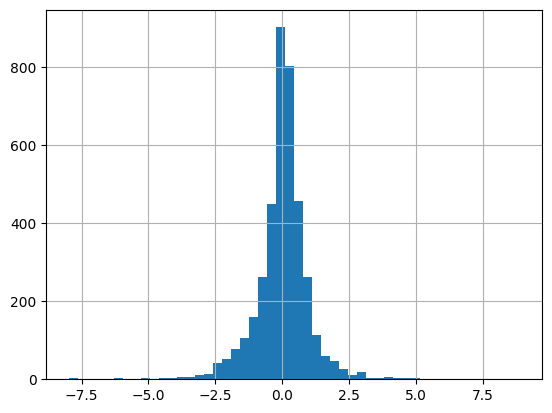

In [41]:
show_distribution(Time930)

## 10:30 AM

count   3930.00000
mean       0.00836
std        0.87679
min       -6.57127
25%       -0.30671
50%        0.05192
75%        0.38937
max        8.66726
Name: Close, dtype: float64


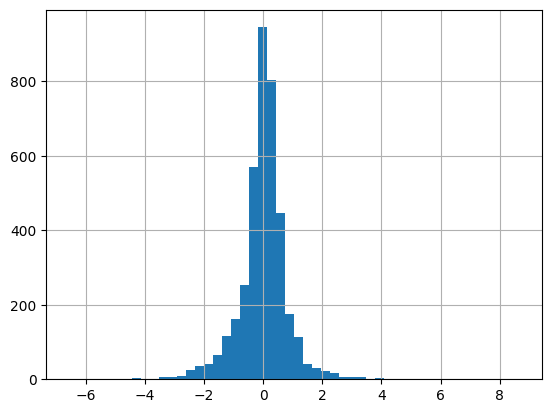

In [43]:
show_distribution(Time1030)

## Noon

count   3930.00000
mean       0.01070
std        0.76089
min       -6.06446
25%       -0.24339
50%        0.04470
75%        0.30020
max        9.65710
Name: Close, dtype: float64


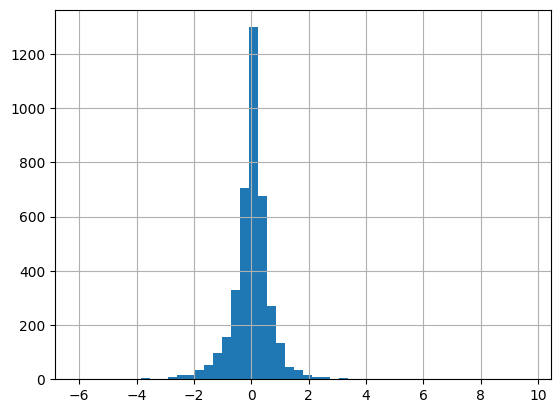

In [44]:
show_distribution(Time1200)

## 1:00 PM

count   3930.00000
mean       0.00949
std        0.72255
min       -6.68887
25%       -0.22819
50%        0.02695
75%        0.26192
max       10.91435
Name: Close, dtype: float64


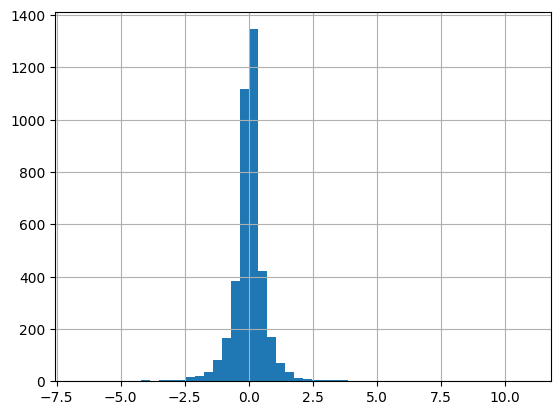

In [45]:
show_distribution(Time1300)

## 2 PM

count   3930.00000
mean       0.01070
std        0.76089
min       -6.06446
25%       -0.24339
50%        0.04470
75%        0.30020
max        9.65710
Name: Close, dtype: float64


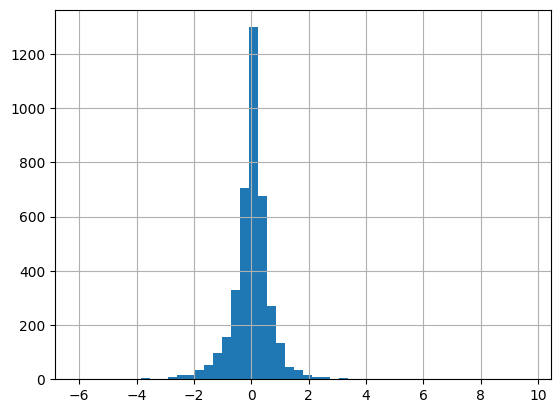

In [46]:
show_distribution(Time1200)

## 3 PM

count   3930.00000
mean       0.00215
std        0.52659
min       -4.75255
25%       -0.15540
50%        0.00713
75%        0.16186
max        6.26942
Name: Close, dtype: float64


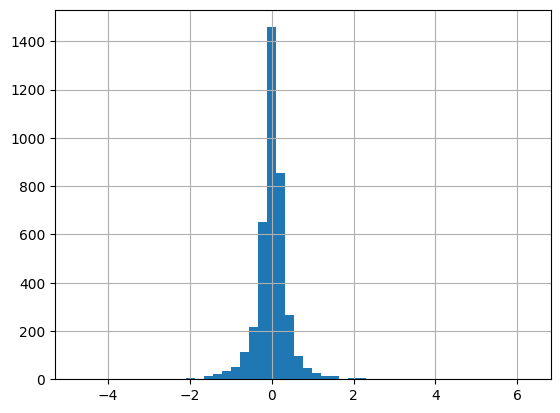

In [47]:
show_distribution(Time1500)

## 3:30 PM

count   3930.00000
mean      -0.00272
std        0.38934
min       -4.05222
25%       -0.12315
50%        0.00184
75%        0.12681
max        4.78464
Name: Close, dtype: float64


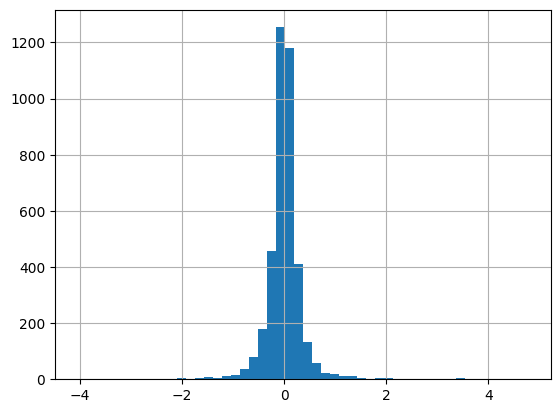

In [48]:
show_distribution(Time1530)

## Next day

count   3926.00000
mean       0.13311
std        2.36402
min      -19.65531
25%       -0.90303
50%        0.33676
75%        1.35392
max       15.11546
Name: Close, dtype: float64


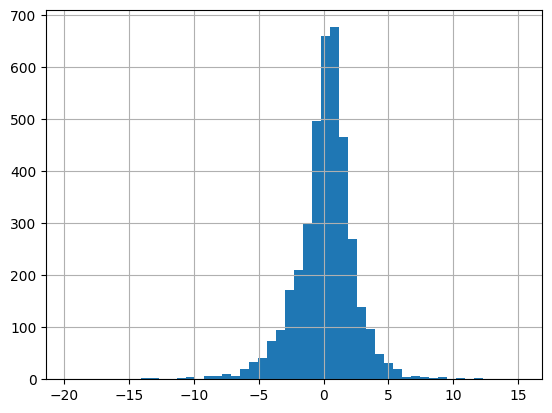

In [49]:
show_distribution(Time930, 1)

## 2 Days Out

count   3922.00000
mean       0.26201
std        3.16414
min      -22.99453
25%       -1.09412
50%        0.57955
75%        1.90866
max       18.44424
Name: Close, dtype: float64


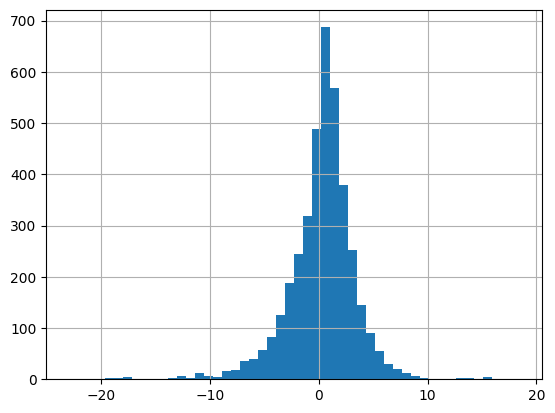

In [51]:
show_distribution(Time930, 2)

## 3 Days Out

count   3919.00000
mean       0.36174
std        3.71276
min      -25.15290
25%       -1.24569
50%        0.78594
75%        2.39203
max       20.34005
Name: Close, dtype: float64


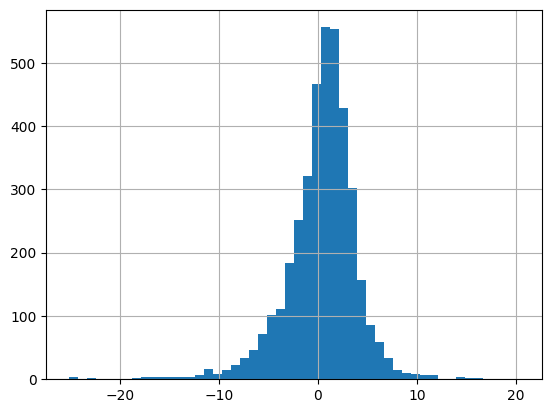

In [53]:
show_distribution(Time930, 3)

## 4 Days Out

count   3915.00000
mean       0.47616
std        4.26751
min      -27.85353
25%       -1.31592
50%        1.07604
75%        2.77225
max       28.00070
Name: Close, dtype: float64


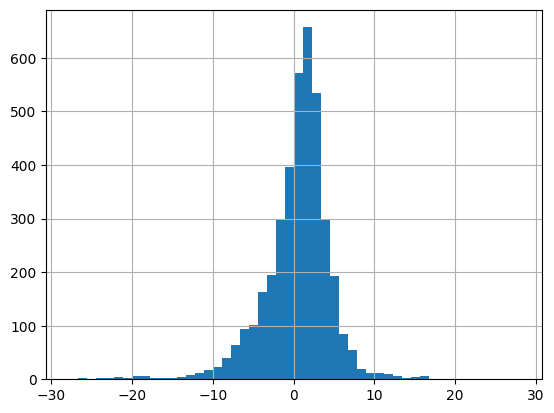

In [54]:
show_distribution(Time930, 4)

## 5 Days Out

count   3911.00000
mean       0.58575
std        4.72697
min      -29.28183
25%       -1.40459
50%        1.26630
75%        3.22569
max       26.30324
Name: Close, dtype: float64


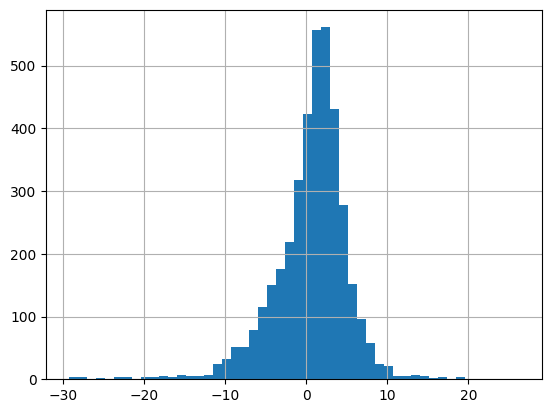

In [55]:
show_distribution(Time930, 5)